# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Multiple Introduction

In [14]:
import sys
sys.path.append('../../')

In [15]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from ML_Regression import ML_Regression
from util.Save_result_return import save_to_csv

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [17]:
from backtesting import Strategy

## Getting the Data

In [18]:
XAUUSD = load_data()

In [19]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [20]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


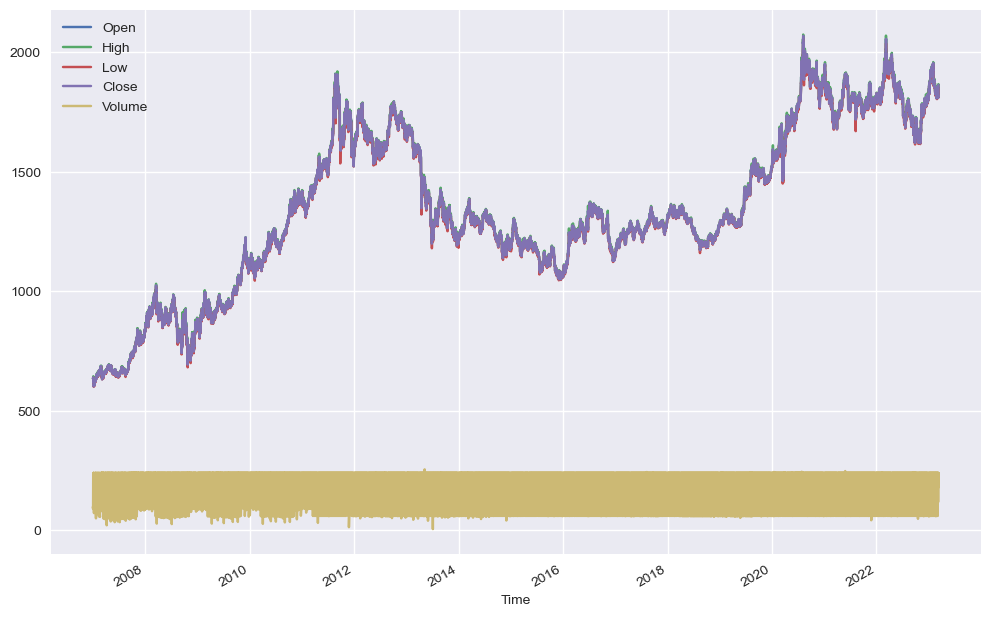

In [21]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [22]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [23]:
strategy = Mutiple_Regression
account_size = 10000

In [24]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        # data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        self.Predict()
        result_test = self.Backtest(self.data_test)
       
        return result_train, result_test

## TF D1

In [25]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [26]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [27]:
train , test = ml.Run()

### In-Sample Backtesting

In [28]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                 11125.810797
Equity Peak [$]                  11689.206415
Return [%]                          11.258108
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    0.665681
Volatility (Ann.) [%]                1.741815
Sharpe Ratio                         0.382177
Sortino Ratio                        0.558647
Calmar Ratio                         0.114888
Max. Drawdown [%]                   -5.794194
Avg. Drawdown [%]                   -0.451723
Max. Drawdown Duration     1993 days 00:00:00
Avg. Drawdown Duration       55 days 00:00:00
# Trades                                 1643
Win Rate [%]                        50.882532
Best Trade [%]                      10.595437
Worst Trade [%]                    -11.757799
Avg. Trade [%]                    

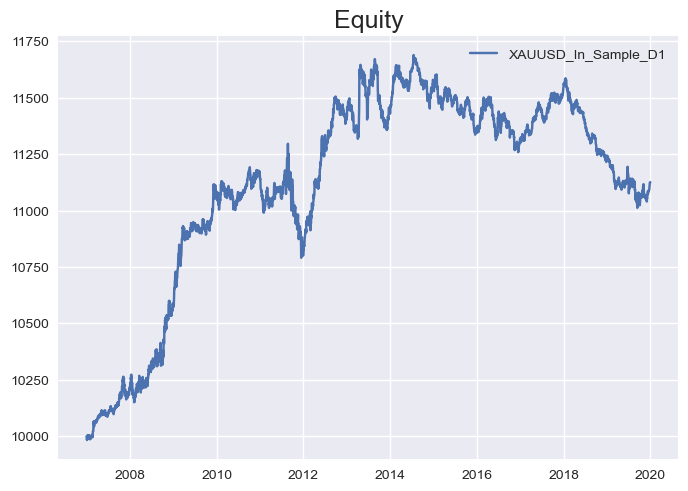

In [29]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [30]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   1164 days 00:00:00
Exposure Time [%]                   99.798184
Equity Final [$]                   9240.53886
Equity Peak [$]                  10105.541639
Return [%]                          -7.594611
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    -1.98846
Volatility (Ann.) [%]                2.715952
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -10.377507
Avg. Drawdown [%]                   -3.621937
Max. Drawdown Duration     1114 days 00:00:00
Avg. Drawdown Duration      384 days 00:00:00
# Trades                                  413
Win Rate [%]                        46.489104
Best Trade [%]                       4.740962
Worst Trade [%]                     -5.408013
Avg. Trade [%]                    

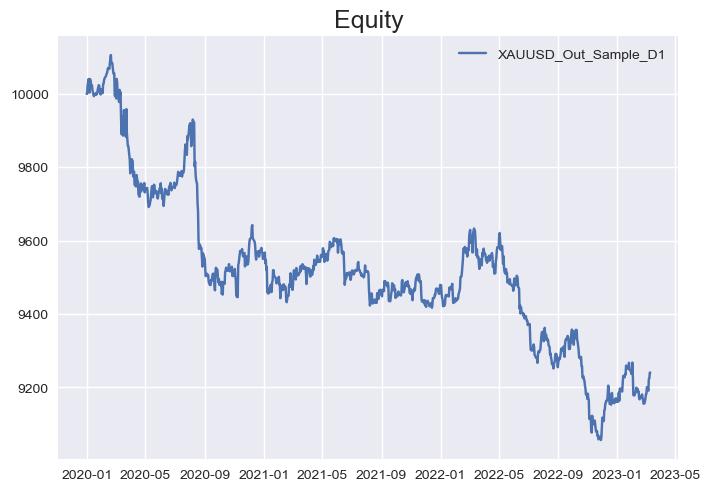

In [31]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [32]:
filename_train = f'result_{TF}_In_Sample.csv'

In [33]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [34]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [35]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H4

In [36]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [37]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [38]:
train , test = ml.Run()

### In-Sample Backtesting

In [39]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                 11097.080554
Equity Peak [$]                  12119.391483
Return [%]                          10.970806
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                    0.649472
Volatility (Ann.) [%]                1.669527
Sharpe Ratio                         0.389016
Sortino Ratio                        0.581344
Calmar Ratio                         0.076024
Max. Drawdown [%]                   -8.543004
Avg. Drawdown [%]                   -0.196148
Max. Drawdown Duration     2805 days 08:00:00
Avg. Drawdown Duration       16 days 14:00:00
# Trades                                 9767
Win Rate [%]                        49.738917
Best Trade [%]                      10.621409
Worst Trade [%]                     -6.274439
Avg. Trade [%]                    

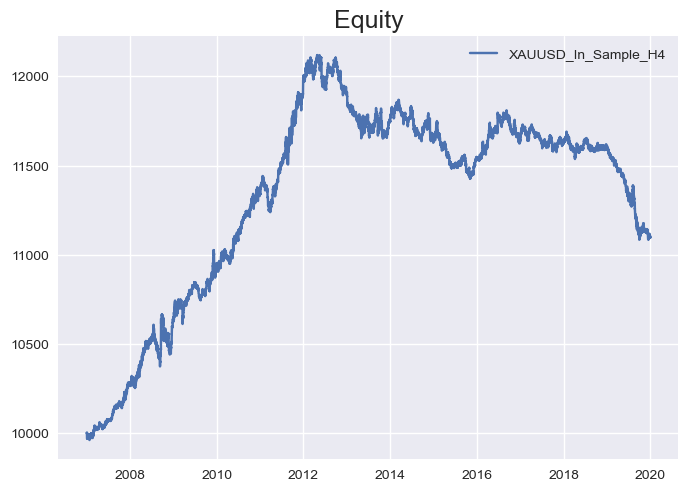

In [40]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [41]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 20:00:00
Exposure Time [%]                   99.960823
Equity Final [$]                   8970.54651
Equity Peak [$]                  10146.118251
Return [%]                         -10.294535
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -2.724743
Volatility (Ann.) [%]                2.514042
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.760961
Avg. Drawdown [%]                   -1.404192
Max. Drawdown Duration      945 days 08:00:00
Avg. Drawdown Duration      105 days 09:00:00
# Trades                                 2366
Win Rate [%]                        48.393914
Best Trade [%]                       3.510538
Worst Trade [%]                     -5.383073
Avg. Trade [%]                    

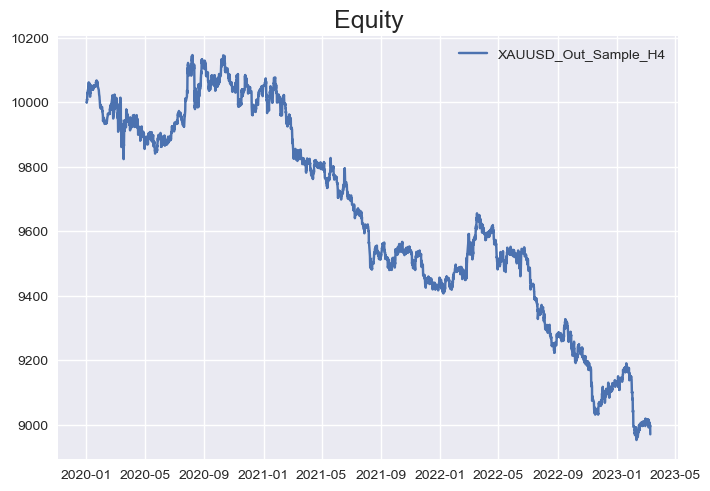

In [42]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [43]:
filename_train = f'result_{TF}_In_Sample.csv'

In [44]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [45]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [46]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H1

In [47]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [48]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [49]:
train , test = ml.Run()

### In-Sample Backtesting

In [50]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  6802.890419
Equity Peak [$]                  10131.373917
Return [%]                         -31.971096
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                   -2.367645
Volatility (Ann.) [%]                2.064392
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -33.647352
Avg. Drawdown [%]                   -0.810678
Max. Drawdown Duration     4344 days 05:00:00
Avg. Drawdown Duration       98 days 22:00:00
# Trades                                17865
Win Rate [%]                        52.549678
Best Trade [%]                        6.23535
Worst Trade [%]                     -8.552351
Avg. Trade [%]                    

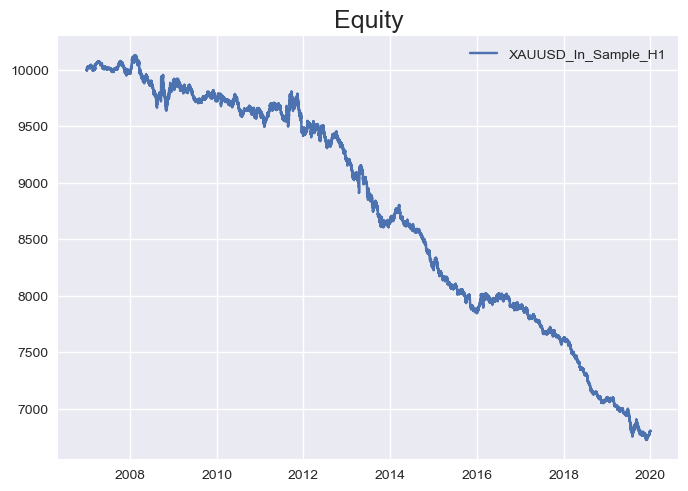

In [51]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [52]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                  8973.227909
Equity Peak [$]                  10301.573347
Return [%]                         -10.267721
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    -2.71735
Volatility (Ann.) [%]                2.470642
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.248282
Avg. Drawdown [%]                   -0.397944
Max. Drawdown Duration      945 days 22:00:00
Avg. Drawdown Duration       19 days 17:00:00
# Trades                                 4458
Win Rate [%]                        53.790938
Best Trade [%]                       2.378468
Worst Trade [%]                     -4.111006
Avg. Trade [%]                    

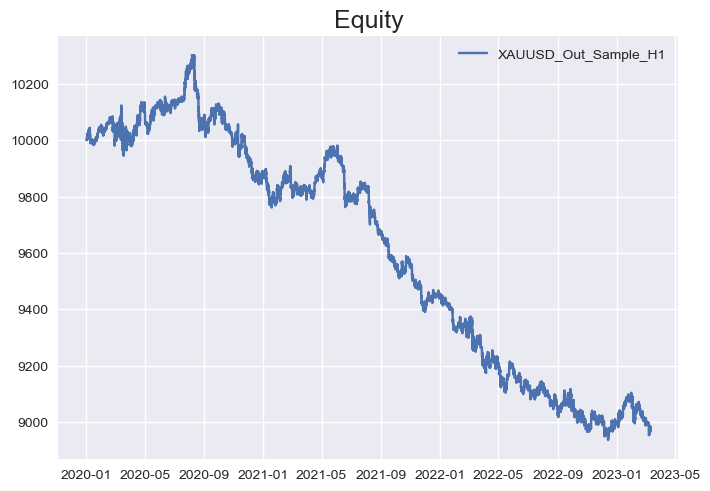

In [53]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [54]:
filename_train = f'result_{TF}_In_Sample.csv'

In [55]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [56]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [57]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M30

In [58]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [59]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [60]:
train , test = ml.Run()

### In-Sample Backtesting

In [61]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                   72.124987
Equity Final [$]                     9.840167
Equity Peak [$]                  10009.788062
Return [%]                         -99.901598
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                  -34.988037
Volatility (Ann.) [%]               16.968986
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.925471
Avg. Drawdown [%]                   -8.366141
Max. Drawdown Duration     4738 days 05:30:00
Avg. Drawdown Duration      395 days 15:30:00
# Trades                                47211
Win Rate [%]                        49.075427
Best Trade [%]                       3.093445
Worst Trade [%]                     -9.600389
Avg. Trade [%]                    

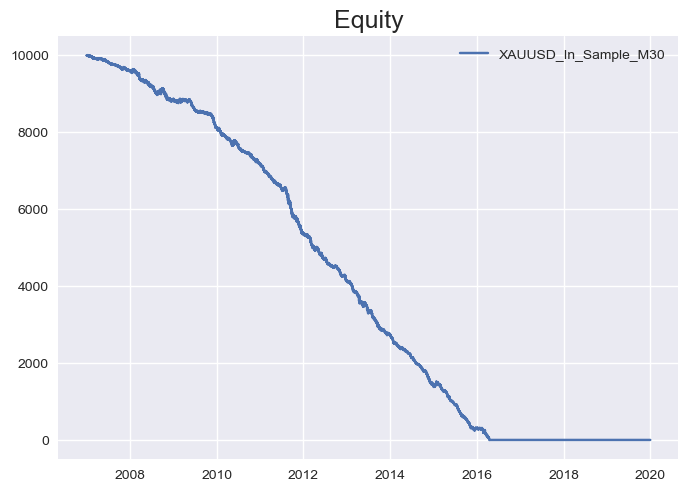

In [62]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [63]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                  5669.123135
Equity Peak [$]                  10024.725011
Return [%]                         -43.308769
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                  -13.439072
Volatility (Ann.) [%]                 2.84459
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -43.448592
Avg. Drawdown [%]                    -4.89306
Max. Drawdown Duration     1157 days 09:30:00
Avg. Drawdown Duration      129 days 07:04:00
# Trades                                15452
Win Rate [%]                        49.657002
Best Trade [%]                       2.036804
Worst Trade [%]                     -4.619286
Avg. Trade [%]                    

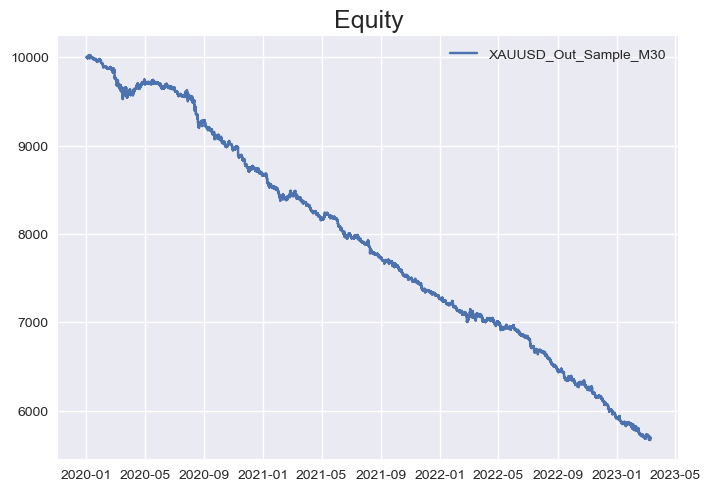

In [64]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [65]:
filename_train = f'result_{TF}_In_Sample.csv'

In [66]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [67]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [68]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M15

In [69]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [70]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [71]:
train , test = ml.Run()

### In-Sample Backtesting

In [72]:
train

Start                     2014-09-23 13:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 08:45:00
Exposure Time [%]                   84.353501
Equity Final [$]                    12.346432
Equity Peak [$]                  10001.052645
Return [%]                         -99.876536
Buy & Hold Return [%]                23.74151
Return (Ann.) [%]                  -64.263129
Volatility (Ann.) [%]               11.984808
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.878248
Avg. Drawdown [%]                  -99.878248
Max. Drawdown Duration     1925 days 08:15:00
Avg. Drawdown Duration     1925 days 08:15:00
# Trades                                44143
Win Rate [%]                        45.189498
Best Trade [%]                       1.878122
Worst Trade [%]                     -2.518568
Avg. Trade [%]                    

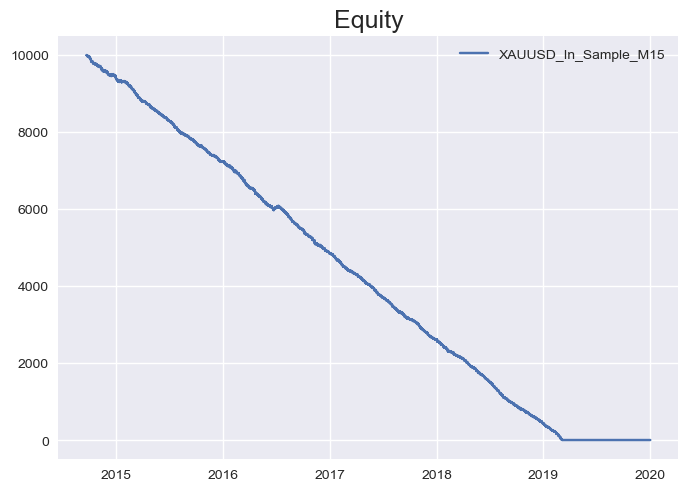

In [73]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [74]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:45:00
Exposure Time [%]                   99.433905
Equity Final [$]                    16.317963
Equity Peak [$]                  10000.782609
Return [%]                          -99.83682
Buy & Hold Return [%]               22.657555
Return (Ann.) [%]                  -80.446231
Volatility (Ann.) [%]                9.929637
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.838933
Avg. Drawdown [%]                  -49.927501
Max. Drawdown Duration     1163 days 16:15:00
Avg. Drawdown Duration      581 days 21:08:00
# Trades                                31979
Win Rate [%]                        48.681948
Best Trade [%]                       2.015583
Worst Trade [%]                     -3.448342
Avg. Trade [%]                    

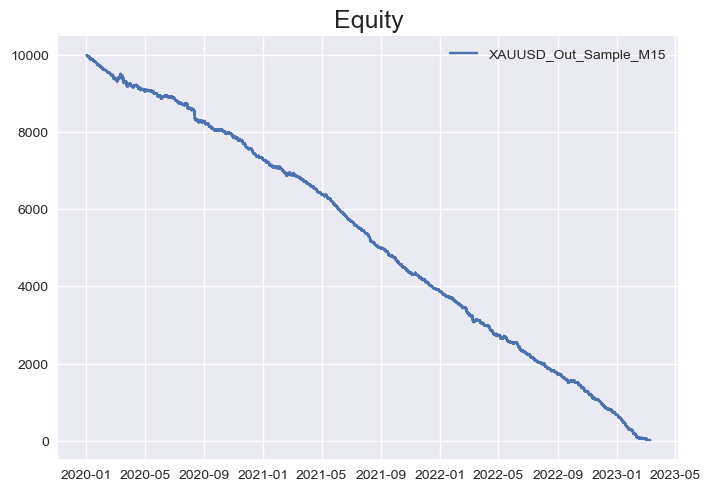

In [75]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [76]:
filename_train = f'result_{TF}_In_Sample.csv'

In [77]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [78]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [79]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M5

In [80]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [81]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [82]:
train , test = ml.Run()

### In-Sample Backtesting

In [83]:
train

Start                     2020-05-15 11:10:00
End                       2022-12-30 21:55:00
Duration                    959 days 10:45:00
Exposure Time [%]                   30.100641
Equity Final [$]                    13.953716
Equity Peak [$]                  10008.261896
Return [%]                         -99.860463
Buy & Hold Return [%]                5.144305
Return (Ann.) [%]                  -86.835017
Volatility (Ann.) [%]                8.260488
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.867802
Avg. Drawdown [%]                  -20.004226
Max. Drawdown Duration      959 days 04:15:00
Avg. Drawdown Duration      191 days 21:14:00
# Trades                                32028
Win Rate [%]                         39.19383
Best Trade [%]                       0.801385
Worst Trade [%]                     -1.876683
Avg. Trade [%]                    

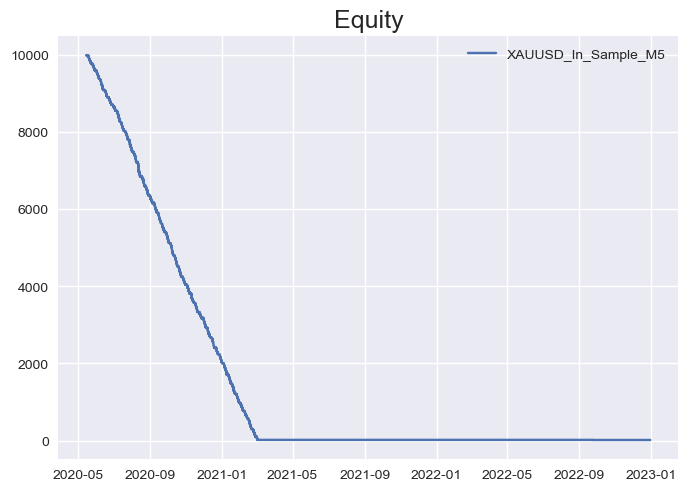

In [84]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [85]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:55:00
Exposure Time [%]                    99.98507
Equity Final [$]                  7424.606795
Equity Peak [$]                  10002.854113
Return [%]                         -25.753932
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                  -71.954038
Volatility (Ann.) [%]                1.076848
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.808079
Avg. Drawdown [%]                  -25.808079
Max. Drawdown Duration       66 days 18:45:00
Avg. Drawdown Duration       66 days 18:45:00
# Trades                                 7587
Win Rate [%]                        35.494926
Best Trade [%]                       0.453433
Worst Trade [%]                      -1.37425
Avg. Trade [%]                    

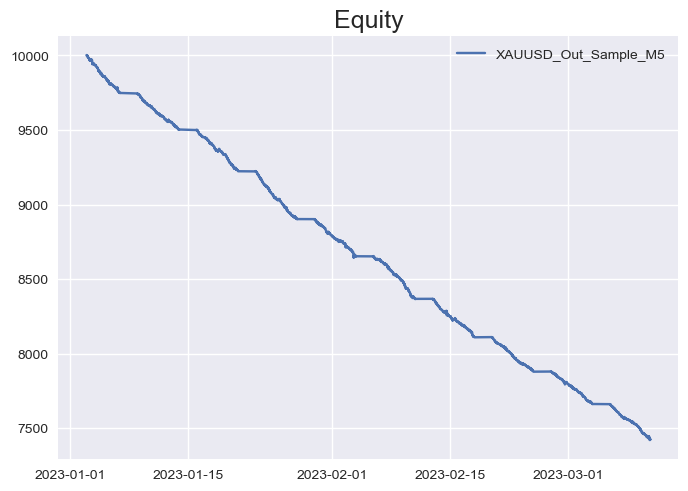

In [86]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [87]:
filename_train = f'result_{TF}_In_Sample.csv'

In [88]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [89]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [90]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M1

In [91]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [92]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [93]:
train , test = ml.Run()

### In-Sample Backtesting

In [94]:
train

Start                     2022-08-16 23:13:00
End                       2022-12-30 21:58:00
Duration                    135 days 22:45:00
Exposure Time [%]                   61.154832
Equity Final [$]                    16.650203
Equity Peak [$]                       10000.0
Return [%]                         -99.833498
Buy & Hold Return [%]                2.688945
Return (Ann.) [%]                  -99.999896
Volatility (Ann.) [%]                0.000509
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.833498
Avg. Drawdown [%]                  -99.833498
Max. Drawdown Duration      135 days 22:44:00
Avg. Drawdown Duration      135 days 22:44:00
# Trades                                30725
Win Rate [%]                        22.538649
Best Trade [%]                       0.874257
Worst Trade [%]                     -0.874074
Avg. Trade [%]                    

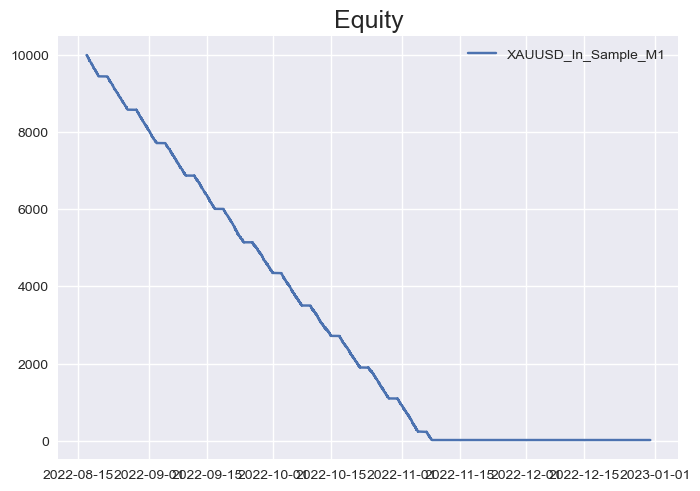

In [95]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [96]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:59:00
Exposure Time [%]                   99.997013
Equity Final [$]                   793.369084
Equity Peak [$]                  10000.234773
Return [%]                         -92.066309
Buy & Hold Return [%]                2.050818
Return (Ann.) [%]                  -99.997995
Volatility (Ann.) [%]                0.001338
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -92.066495
Avg. Drawdown [%]                  -92.066495
Max. Drawdown Duration       66 days 18:57:00
Avg. Drawdown Duration       66 days 18:57:00
# Trades                                25327
Win Rate [%]                        20.148458
Best Trade [%]                       0.871652
Worst Trade [%]                     -0.812181
Avg. Trade [%]                    

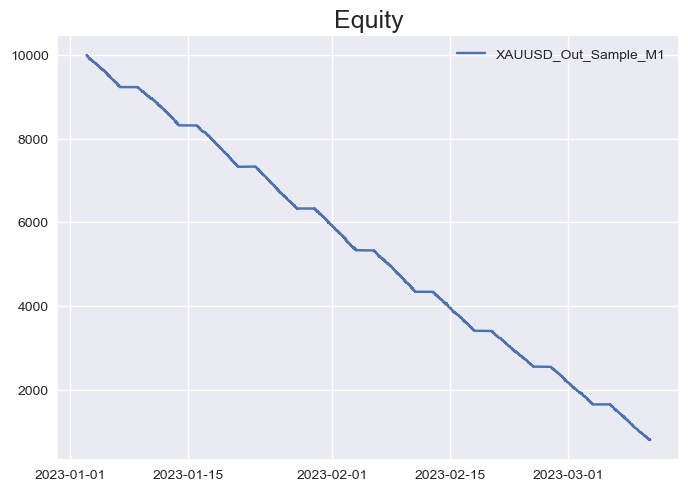

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [98]:
filename_train = f'result_{TF}_In_Sample.csv'

In [99]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')